# Neural Network

## Table of content

- [Experiment on how imbalance affect the performance](#experiment-on-how-imbalance-affect-the-performance)
    - [Without handling imbalance](#Without-handling-imbalance)
    - [Using class weights](#Using-class-weights)
    - [Using oversampling ](#Using-oversampling )
    - [Results of the experiment](#Results-of-the-experiment)
- [Find the best model](#Find-the-best-model)

In [6]:
from Functions import get_result, get_best_threshold, plot_roc_curve, save_metrics_to_json
from imblearn.over_sampling import SMOTE
from keras import Sequential, models, utils, backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, BatchNormalization
from keras.losses import BinaryCrossentropy
from keras.metrics import (AUC, BinaryAccuracy, Precision, Recall, Metric, F1Score, 
                           TruePositives, FalsePositives, TrueNegatives, FalseNegatives)
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.utils import class_weight
import datetime
import json
import keras_tuner as kt
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import numpy as np
import optuna
import pandas as pd
import tensorflow as tf

Load the datasets for training (remember they are scaled)

In [2]:
filenames = ['X_train.pkl', 'Y_train.pkl', 'X_val.pkl', 'Y_val.pkl', 'X_test.pkl', 'Y_test.pkl']
data_folder = '../data/'
dataframes = [pd.read_pickle(data_folder + filename) for filename in filenames]
X_train, Y_train, X_val, Y_val, X_test, Y_test = dataframes

In [3]:
BATCH_SIZE = 2048

In [5]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

We will start by creating a function to produce some plots of the models performance and loss on the training and validation set. These will help us check for overfitting.

In [7]:
def plot_training_metrics(history):
    metrics = [
        'loss', 
        'recall', 
        'precision', 
        #'F1'
        'prc'
    ]
    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

Now, lets do an experiment of how our neural network would do, when we do not handle the imbalance in our dataset. Afterwards we'll try two different techniques to handle the imbalance.

## Experiment on how imbalance affect the performance
We'll create a function to create a simple model, which we can use for this experiment.

In [9]:
def get_simple_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(),
        loss=BinaryCrossentropy(from_logits=False),
        metrics=METRICS
    )

    return model

### Without handling imbalance

In [10]:
model = get_simple_model()

In [12]:
history_unhandled = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
134/134 [==============================] - 2s 17ms/step - loss: 0.0113 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 272559.0000 - fn: 385.0000 - accuracy: 0.9986 - precision: 0.0000e+00 - recall: 0.0000e+00 - prc: 0.0016 - val_loss: 0.0108 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 34070.0000 - val_fn: 48.0000 - val_accuracy: 0.9986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_prc: 0.0014
Epoch 2/20
134/134 [==============================] - 2s 14ms/step - loss: 0.0111 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 272559.0000 - fn: 385.0000 - accuracy: 0.9986 - precision: 0.0000e+00 - recall: 0.0000e+00 - prc: 0.0015 - val_loss: 0.0108 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 34070.0000 - val_fn: 48.0000 - val_accuracy: 0.9986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_prc: 0.0014
Epoch 3/20
134/134 [==============================] - 2s 14ms/step - loss: 0.0109 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 272559.0000 - fn: 385.0000 - accurac

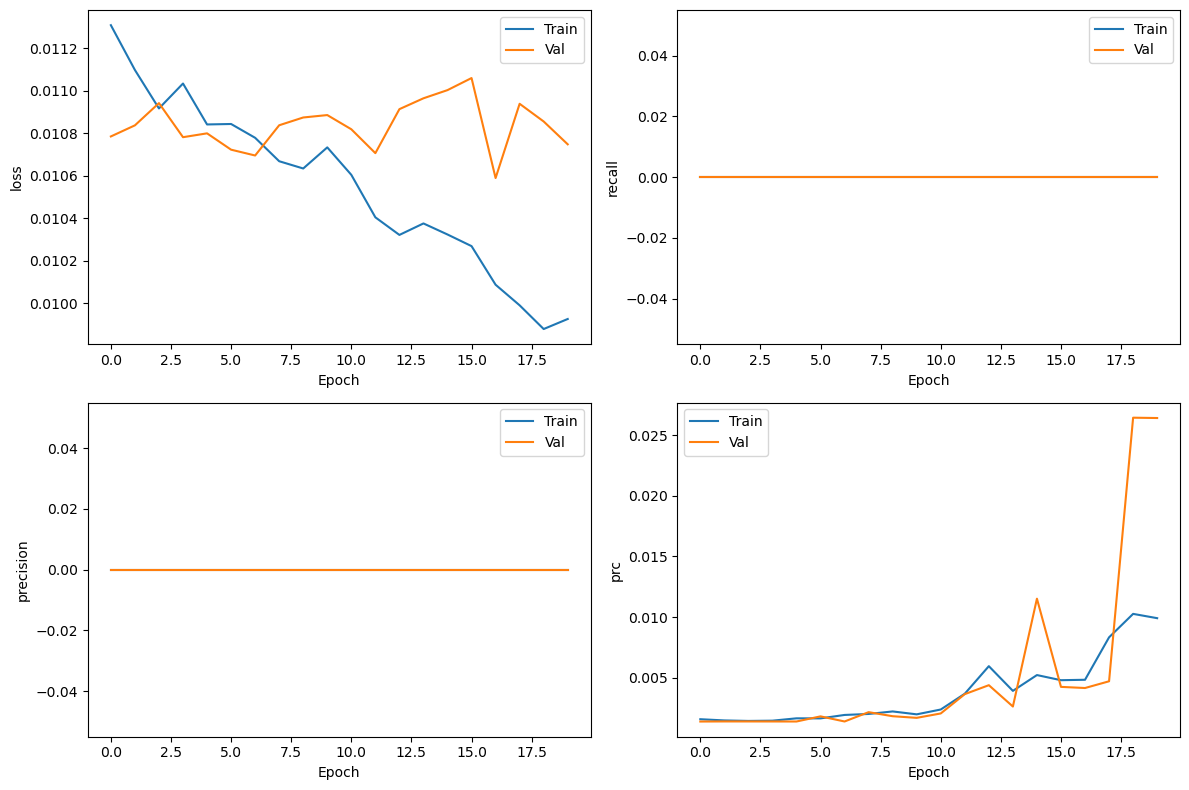

In [13]:
plot_training_metrics(history_unhandled)

In [14]:
val_predictions = model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


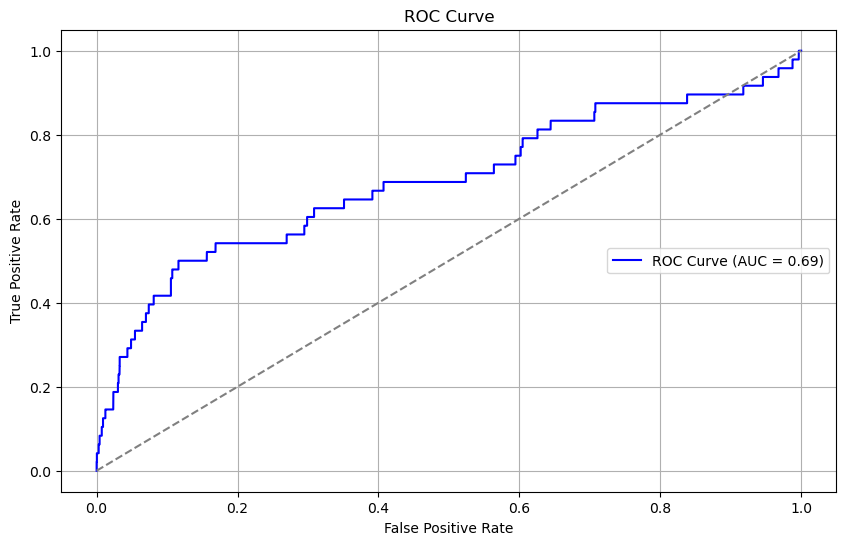

0.6884490265140397

In [15]:
plot_roc_curve(Y_val, val_predictions)

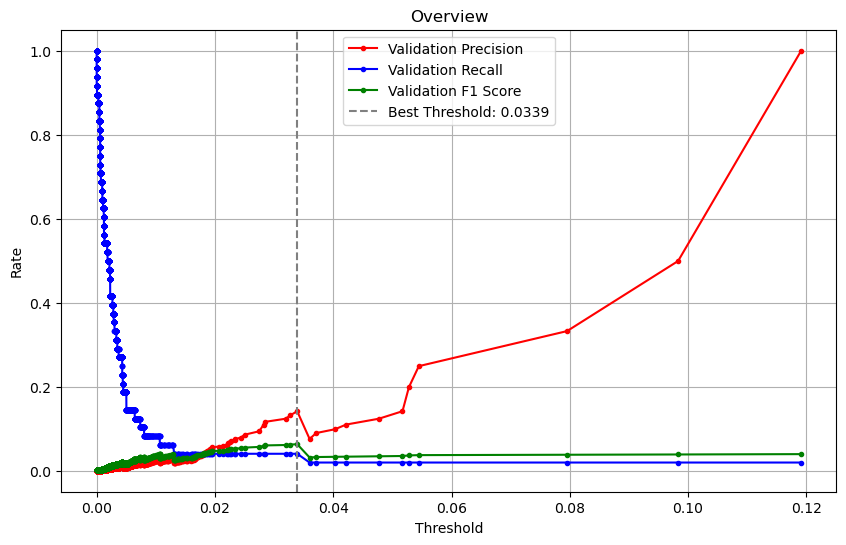

In [16]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [17]:
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


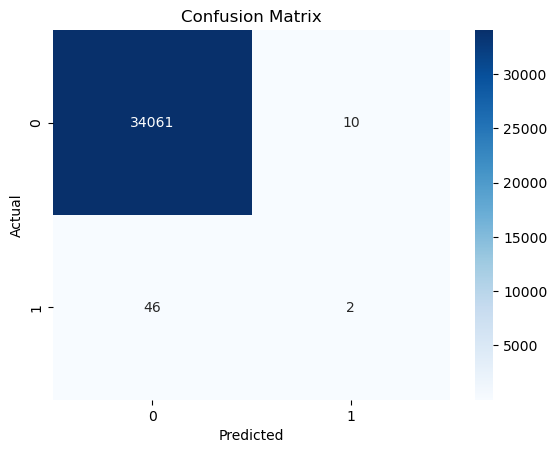

Recall       = 0.04
Precision    = 0.17
F1           = 0.07


In [ ]:
_ = get_result(Y_test, test_predictions, best_threshold, visualize=True)

### Using class weights

In [8]:
# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict

{0: 0.5007062691013688, 1: 354.4727272727273}

In [20]:
model = get_simple_model()

history_class_weights = model.fit(
    X_train,
    Y_train,
    class_weight=class_weights_dict,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
134/134 [==============================] - 4s 16ms/step - loss: 0.8001 - tp: 204.0000 - fp: 146322.0000 - tn: 160307.0000 - fn: 229.0000 - accuracy: 0.5227 - precision: 0.0014 - recall: 0.4711 - prc: 0.0015 - val_loss: 0.6596 - val_tp: 17.0000 - val_fp: 10117.0000 - val_tn: 23953.0000 - val_fn: 31.0000 - val_accuracy: 0.7026 - val_precision: 0.0017 - val_recall: 0.3542 - val_prc: 0.0015
Epoch 2/20
134/134 [==============================] - 2s 14ms/step - loss: 0.7483 - tp: 206.0000 - fp: 135284.0000 - tn: 137275.0000 - fn: 179.0000 - accuracy: 0.5037 - precision: 0.0015 - recall: 0.5351 - prc: 0.0017 - val_loss: 0.6008 - val_tp: 11.0000 - val_fp: 6899.0000 - val_tn: 27171.0000 - val_fn: 37.0000 - val_accuracy: 0.7967 - val_precision: 0.0016 - val_recall: 0.2292 - val_prc: 0.0017
Epoch 3/20
134/134 [==============================] - 2s 14ms/step - loss: 0.6973 - tp: 218.0000 - fp: 126640.0000 - tn: 145919.0000 - fn: 167.0000 - accuracy: 0.5354 - precision: 0.0017 - recall: 0.

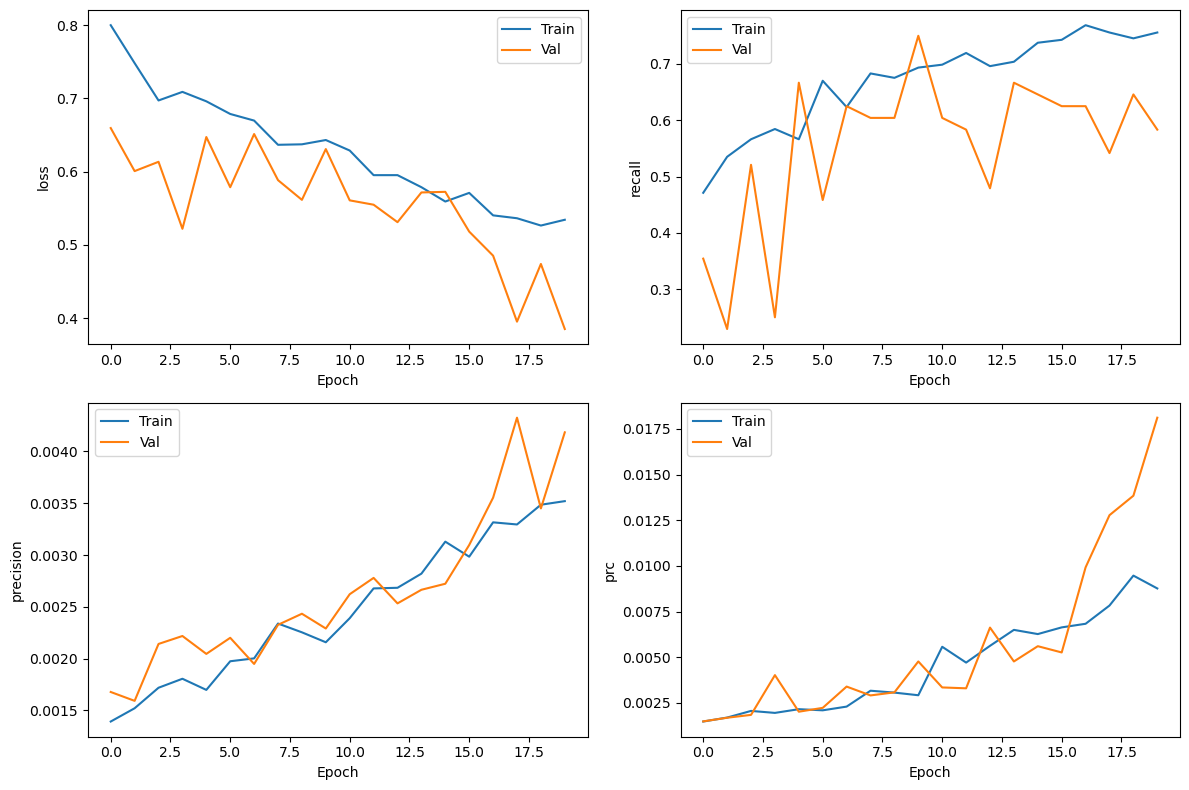

In [21]:
plot_training_metrics(history_class_weights)

In [22]:
val_predictions = model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


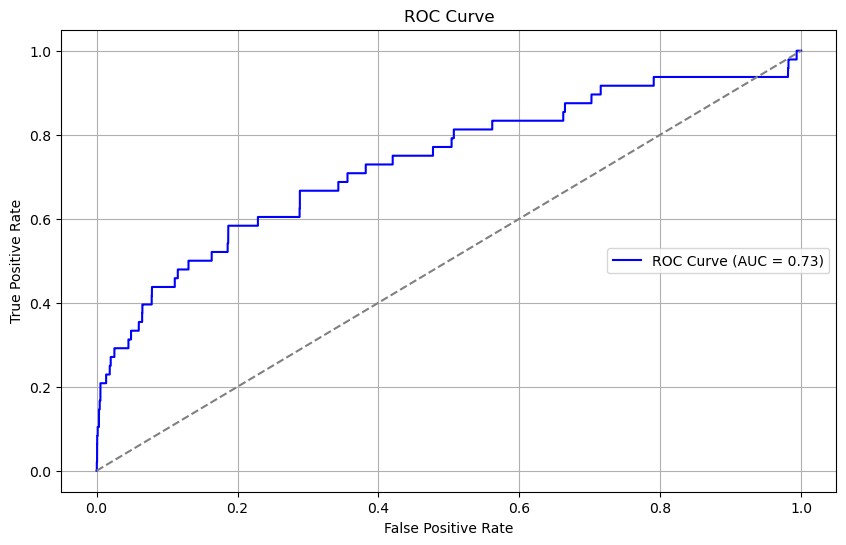

0.734179018687017

In [23]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:65: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


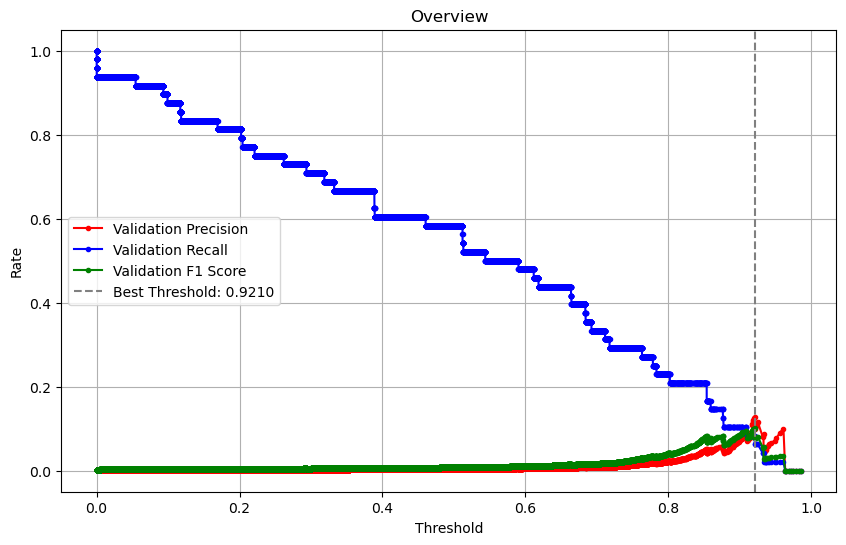

In [24]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [25]:
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 3ms/step


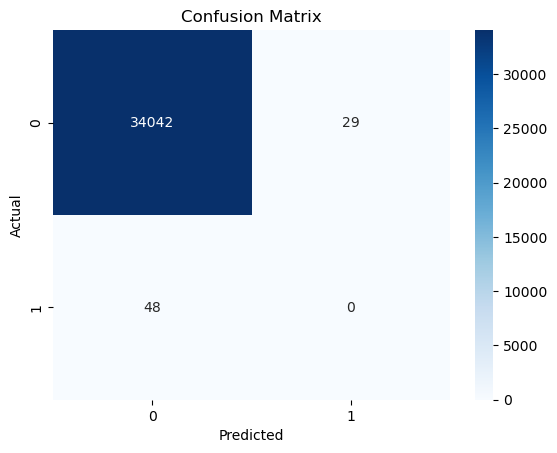

Recall       = 0.0
Precision    = 0.0
F1           = 0.0


In [ ]:
_ = get_result(Y_test, test_predictions, best_threshold, visualize=True)

### Using oversampling 

There are different kinds of techniques for oversampling. The simplest would be Random oversampling, which just duplicates existing samples from the minority class to balance the distribution. However, this can result in overfitting as the same samples are repeated. Instead we could use Synthetic Minority Over-sampling Technique (SMOTE). The way SMOTE does it, is by generating synthetic examples in the feature space of the minority class, which helps to overcome the overfitting problem, since it is not just a copy of existing samples. The drawback of SMOTE is it can generate noisy or unrealistic samples. We will however use SMOTE to oversample on the risky customers.

In [9]:
smote = SMOTE(sampling_strategy='minority') 
X_train_oversampled, Y_train_oversampled = smote.fit_resample(X_train, Y_train)
Y_train_oversampled.value_counts()

RISK
0    272559
1    272559
Name: count, dtype: int64

In [28]:
model = get_simple_model()

history_oversampled = model.fit(
    X_train_oversampled,
    Y_train_oversampled,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, Y_val)
)

Epoch 1/20
267/267 [==============================] - 6s 15ms/step - loss: 0.3290 - tp: 241290.0000 - fp: 60052.0000 - tn: 246577.0000 - fn: 31317.0000 - accuracy: 0.8423 - precision: 0.8007 - recall: 0.8851 - prc: 0.9184 - val_loss: 4.4050 - val_tp: 48.0000 - val_fp: 33689.0000 - val_tn: 381.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0126 - val_precision: 0.0014 - val_recall: 1.0000 - val_prc: 0.0049
Epoch 2/20
267/267 [==============================] - 4s 14ms/step - loss: 0.1160 - tp: 265025.0000 - fp: 15319.0000 - tn: 257240.0000 - fn: 7534.0000 - accuracy: 0.9581 - precision: 0.9454 - recall: 0.9724 - prc: 0.9864 - val_loss: 0.7778 - val_tp: 30.0000 - val_fp: 9229.0000 - val_tn: 24841.0000 - val_fn: 18.0000 - val_accuracy: 0.7290 - val_precision: 0.0032 - val_recall: 0.6250 - val_prc: 0.0123
Epoch 3/20
267/267 [==============================] - 4s 13ms/step - loss: 0.0830 - tp: 267561.0000 - fp: 10517.0000 - tn: 262042.0000 - fn: 4998.0000 - accuracy: 0.9715 - precision: 0.9622 -

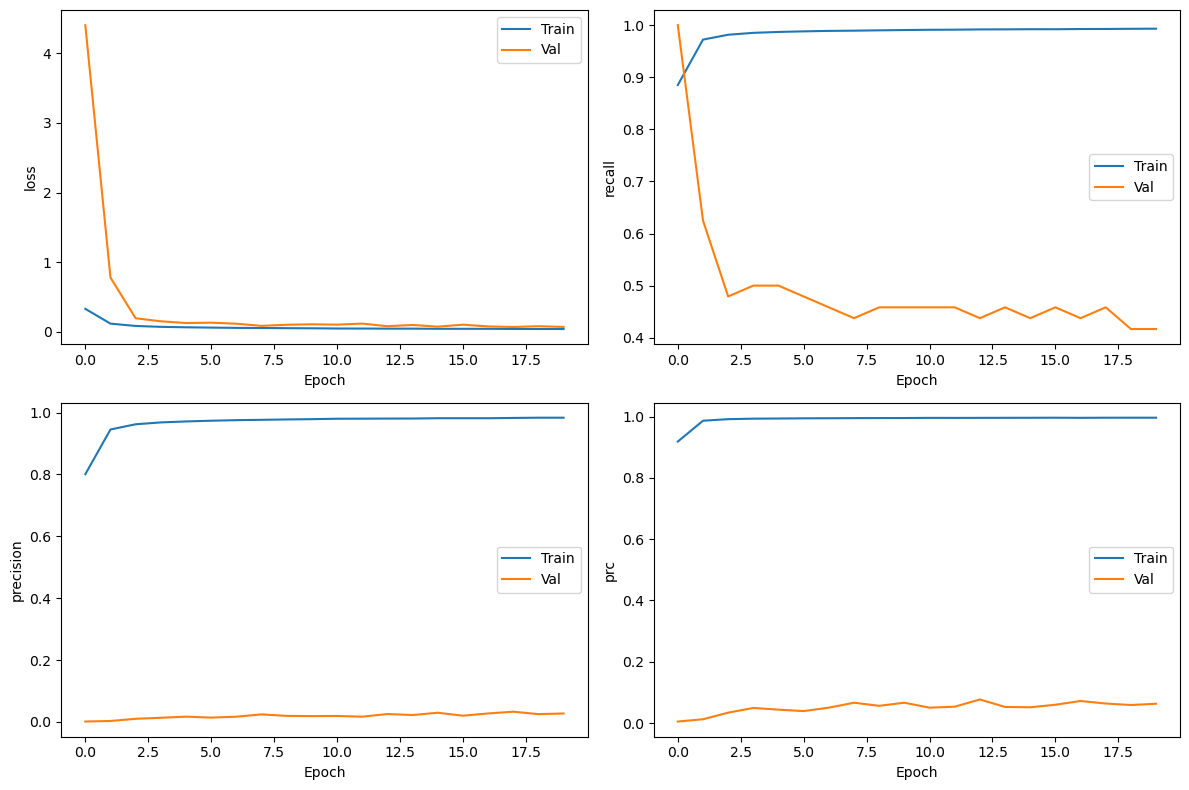

In [29]:
plot_training_metrics(history_oversampled)

In [30]:
val_predictions = model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 2ms/step


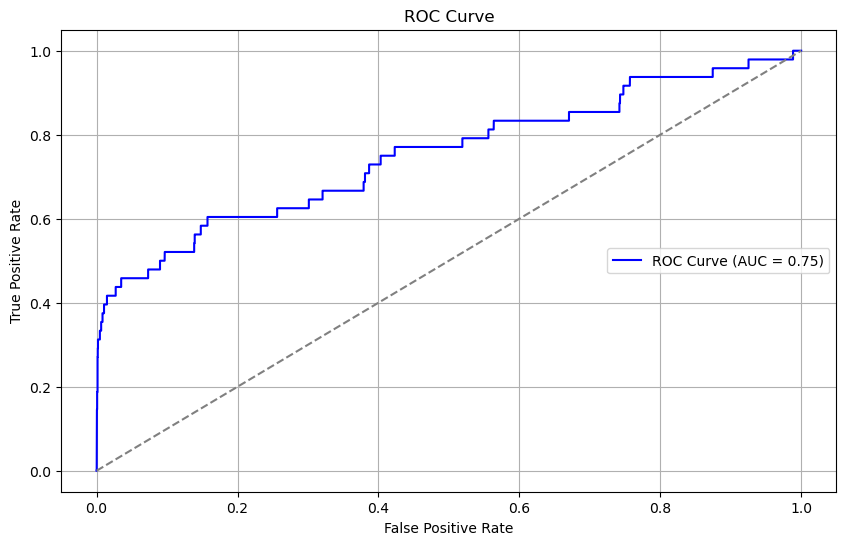

0.7521236914196263

In [31]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:65: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


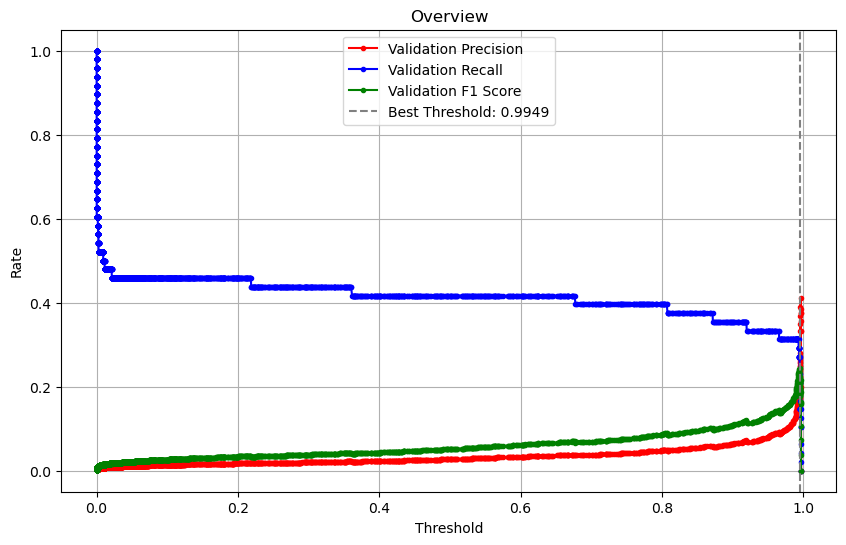

In [32]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [33]:
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 3ms/step


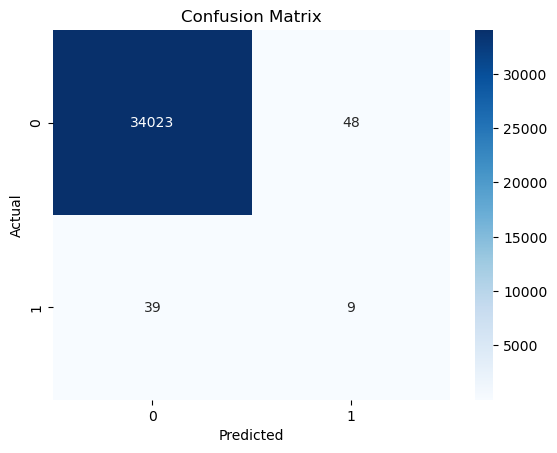

Recall       = 0.19
Precision    = 0.16
F1           = 0.17


In [ ]:
_ = get_result(Y_test, test_predictions, best_threshold, visualize=True)

### Results of the experiment
- All the models could use some regularization (we will handle that later)
- Using nothing to handle the imbalance did okay but not good (was not the point here)
- Using class weights was the worst of the three models
    - Could be the result of too high a weight for the risky customers and too low for the normal customers, which would mean that the model focuses more on reducing errors for risky customers. However, it did not do much better on the recall anyway. Trying out different weights could improve the performance.
- Using oversampling was the the best but again not really good.

Handling imbalance is clearly an important part to create a good model. However as demonstrated, you need to test out different methods to find out what works best.

## Find the best model
First lets set up MLflow to track our experiment

In [53]:
# Read the JSON file
with open('../config.json', 'r') as file:
    config = json.load(file)

# Set the tracking URI for logging using the values from the JSON file
mlflow.set_tracking_uri(uri=f"http://{config['host']}:{config['port']}")

exp_name = "Credit_Card_Approval"
experiment = mlflow.get_experiment_by_name(exp_name)
exp_id = experiment.experiment_id
exp_id

'1'

In [54]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=exp_id)

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1761771384696, experiment_id='1', last_update_time=1761771384696, lifecycle_stage='active', name='Credit_Card_Approval', tags={'mlflow.note.content': 'This is the Credit Card Approval project. This '
                        'experiment contains the models for credit card '
                        'approval.',
 'project_name': 'credit-card-approval'}>

In [55]:
base_run_name = "neaural_network"

In [56]:
prior_runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.runName LIKE '{base_run_name}%'",
    output_format="pandas",
    max_results=100,
)

print(f"Number of prior runs with base name '{base_run_name}': {len(prior_runs)}")

Number of prior runs with base name 'neaural_network': 0


In [57]:
run_name = f"{base_run_name}_v{int(len(prior_runs))+1}"
run_name

'neaural_network_v1'

Now lets try to find the possible model. To do that we'll create a function that can build a model with different hyperparameters.

In [58]:
def build_model(trial):
    """
    Build and compile a model using different hyperparameters.

    Parameters:
        trial (optuna.trial.Trial): Object for defining hyperparameter search space.

    Returns:
        model: A compiled Keras model.
    """
    model = Sequential()

    # Input layer units
    input_units = trial.suggest_int("input_layer", 64, 512, step=32)
    l2_input = trial.suggest_float("l2_0", 1e-4, 1e-2, log=True)  

    model.add(
        Dense(
            units=input_units,
            input_shape=(X_train_oversampled.shape[1],),
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(l2_input),
        )
    )

    # Always add a Dropout layer after the first layer
    model.add(Dropout(rate=trial.suggest_float("dropout_input", 0.2, 0.5)))

    # Number of hidden layers
    n_layers = trial.suggest_int("num_layers", 1, 5)
    previous_units = input_units

    for i in range(n_layers):
        units_i = trial.suggest_int(f"units_{i+1}", 32, previous_units, step=32)
        l2_i = trial.suggest_float(f"l2_{i+1}", 1e-4, 1e-2, log=True)

        model.add(
            Dense(
                units=units_i,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(l2_i),
            )
        )

        # Optional batch norm
        if trial.suggest_categorical(f"batch_norm_{i}", [False, True]):
            model.add(BatchNormalization())

        # Optional dropout
        if trial.suggest_categorical(f"dropout_{i}", [False, True]):
            model.add(Dropout(rate=trial.suggest_float(f"dropout_rate_{i}", 0.2, 0.5)))

        previous_units = units_i

    model.add(Dense(1, activation="sigmoid"))

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=METRICS,
    )

    return model

In [59]:
# Metric we want to monitor during training
monitor = 'val_prc'

In [60]:
# Apply SMOTE to training data to handle class imbalance (again for clarity)
smote = SMOTE(sampling_strategy='minority') 
X_train_oversampled, Y_train_oversampled = smote.fit_resample(X_train, Y_train)
Y_train_oversampled.value_counts()

RISK
0    272559
1    272559
Name: count, dtype: int64

We are going to utilize a callback when running the RandomSearch:
- EarlyStopping: To stop training when the model stop to improve on the monitored metric for a number of epochs. Here we also restore the weights, which resulted in the best performence on the monitored metric.

In [61]:
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [BATCH_SIZE, BATCH_SIZE * 2])

    model = build_model(trial)

    early_stopping = EarlyStopping(
        monitor=monitor,
        patience=3,
        mode="max",
        restore_best_weights=True,
    )

    with mlflow.start_run(nested=True):
        history = model.fit(
            X_train_oversampled,
            Y_train_oversampled,
            epochs=20,
            batch_size=batch_size,
            validation_data=(X_val, Y_val),
            callbacks=[early_stopping],
            verbose=0,
        )

        # Evaluate the model
        preds = model.predict(X_val, batch_size=batch_size)
        metrics = get_result(Y_val, preds)

        # Log the parameters
        mlflow.log_params(trial.params)
        mlflow.log_params({"epochs": len(history.history['loss'])})
        
        # Log the metrics
        mlflow.log_metrics(metrics)

        # Log tags
        mlflow.set_tags(
            tags={
                "project": "Credit Card Approval",
                "optimizer_engine": "optuna",
                "model_family": "Neaural Network",
                "feature_set_version": 1,
                "version": int(len(prior_runs))+1
            }
        )

    return metrics['f1']

In [ ]:
artifact_path = "model"

with mlflow.start_run(run_name=run_name) as parent_run:
    parent_run_id = parent_run.info.run_id
    study = optuna.create_study(
        direction="maximize",
        study_name="NeauralNetwork_Optimization",
    )

    study.optimize(objective, n_trials=50)

    # Log the best parameters found during the optimization
    mlflow.log_params(study.best_params)

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Credit Card Approval",
            "optimizer_engine": "optuna",
            "model_family": "Neaural Network",
            "feature_set_version": 1,
            "version": int(len(prior_runs))+1
        }
    )

    # train the final model with the best hyperparameters
    best_trial = study.best_trial
    model = build_model(best_trial)

    # Before training the best model again, we are going to utilize some additional callbacks:
    # - ModelCheckpoint: To save the best weights depending on a monitored metric.
    # - TensorBoard: To visualize training progress and metrics in TensorBoard.
    early_stopping = EarlyStopping(
        monitor=monitor,
        patience=5,
        mode="max",
        restore_best_weights=True,
    )

    # Model checkpoint callback for securing best weights
    model_checkpoint_callback = ModelCheckpoint(
        filepath=r'tmp/NN_best_model.keras',
        save_weights_only=True, 
        monitor=monitor,
        mode='max',
        save_best_only=True
    )

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # directory to store logs
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = model.fit(
            X_train_oversampled,
            Y_train_oversampled,
            epochs=50,
            batch_size=study.best_params['batch_size'],
            validation_data=(X_val, Y_val),
            callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback],
            verbose=0,
        )
    
    # Evaluate the model
    preds = model.predict(X_val, batch_size=study.best_params['batch_size'])
    metrics = get_result(Y_val, preds)

    # Log the number of epochs
    mlflow.log_params({"epochs": len(history.history['loss'])})
    
    # Log the metrics
    mlflow.log_metrics(metrics)

    # Log the final model
    model_info = mlflow.keras.log_model(model, 
                            #  artifact_path=artifact_path
                            name=artifact_path,
                            #input_example=X_train_oversampled.iloc[[0]]
                             )
    model_uri = model_info.model_uri

[I 2025-12-01 21:25:36,394] A new study created in memory with name: NeauralNetwork_Optimization


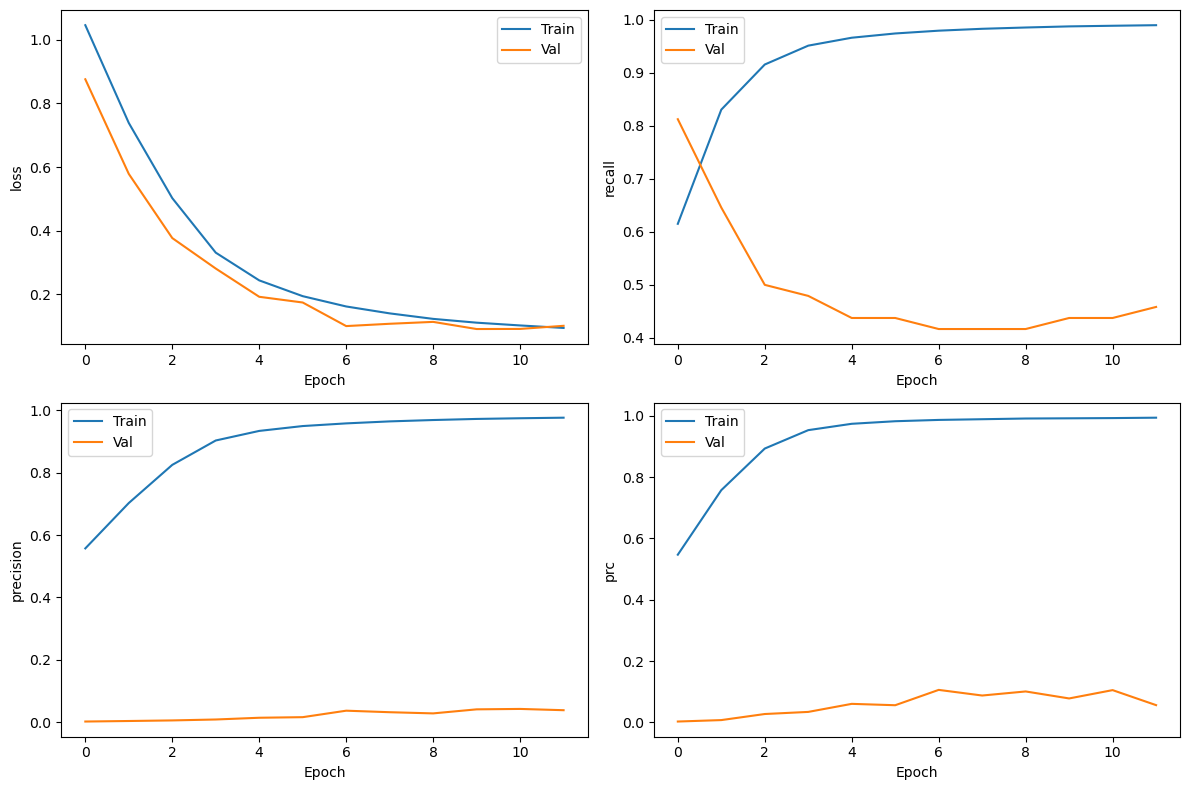

In [ ]:
plot_training_metrics(history)

It's overfitting VERY much!

In [ ]:
print(f'parent_run_id: {parent_run_id}')
print(f'model_uri: {model_uri}')

parent_run_id: 423805d4ee164203b3bb6a7a7f4b762b
model_uri: models:/m-fecce9a679dd45dc918c6c82175b1b9e


In [ ]:
runs = mlflow.search_runs(
    experiment_ids=[exp_id],
    filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'",
    output_format='pandas'
)

In [ ]:
param_cols = [c for c in runs.columns if c.startswith("params.")]

display(runs[[
    'run_id', 
    'metrics.f1', 
    'metrics.recall', 
    'metrics.precision',
    'metrics.accuracy'
    ] + param_cols]
    .sort_values(by='metrics.f1', ascending=False)
    .head(10))

,run_id,metrics.f1,metrics.recall,metrics.precision,metrics.accuracy,params.dropout_input,params.units_2,params.l2_0,params.l2_1,params.dropout_1,...,params.dropout_2,params.units_3,params.dropout_rate_2,params.l2_4,params.dropout_rate_3,params.units_4,params.l2_3,params.dropout_3,params.batch_norm_3,params.batch_norm_2
2,a578390b6c994487a9a7de7015f5a114,0.099448,0.375000,0.057325,0.990445,0.2180514951681586,32,0.0003392084044741261,0.001968616443860666,True,...,True,32,0.37128529860846016,0.002020540317831872,0.45945206365239893,32,0.000932987807857621,True,True,True
5,db5b1e3639a8491893c43fb53424f863,0.078704,0.354167,0.044271,0.988335,0.20240611776802145,32,0.0040429535868505345,0.0018438814321909663,False,...,True,32,0.2964119786305456,0.004467558888389989,0.42424294440369503,32,0.005102255198746088,True,True,True
4,9d9892cf5dbd44499eda5faf1a33bf27,0.056604,0.437500,0.030259,0.979483,0.20730202973721648,None,0.0007919291435597022,0.004883686369103741,None,...,None,None,None,None,None,None,None,None,None,None
7,bf4036f8be154304950e10223cec2d71,0.053571,0.375000,0.028846,0.981359,0.318284650362565,32,0.0009041519614306651,0.000990023413197049,True,...,False,32,None,0.00011160479891943901,None,32,0.00033608338080083725,False,False,True
1,86715d1d0ae34d318ec31cdc43173cfc,0.053204,0.458333,0.028241,0.977050,0.4796687495260424,64,0.0001909091116799344,0.0020859716643465394,True,...,None,None,None,None,None,None,None,None,None,None
6,24de54622af6432f92da2706f3a29850,0.048780,0.416667,0.025907,0.977138,0.36102705439064653,None,0.0086335948284342,0.0013430350542088367,None,...,None,None,None,None,None,None,None,None,None,None
3,eb042e33c8f748c99909ea455be2e507,0.043435,0.458333,0.022798,0.971599,0.22677108231692464,224,0.00015289988933018782,0.007525342387018014,False,...,False,32,None,None,None,None,0.0007610476316645635,None,None,False
9,be6c3e1a5ed642e686e2371673fe0962,0.032881,0.479167,0.017024,0.960344,0.2627815127474564,None,0.006793718997064123,0.0003364891304982669,None,...,None,None,None,None,None,None,None,None,None,None
0,785760987b624503b03cccba0ea98fc2,0.030056,0.500000,0.015494,0.954599,0.4487802976815787,416,0.007285003003631308,0.00011362984837425399,True,...,None,None,None,None,None,None,None,None,None,None
8,f8a508660fc743a784db841863a09912,0.010665,0.625000,0.005378,0.836860,0.3795878719549368,64,0.0001458236079968518,0.0002615324514444892,False,...,True,64,0.263382793473104,0.001232123936291617,0.46034994469149554,64,0.0062948639071133934,True,True,True


In [ ]:
loaded_model = mlflow.keras.load_model(model_uri)

In [ ]:
# Predict on the val set
val_predictions = loaded_model.predict(X_val, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 17ms/step


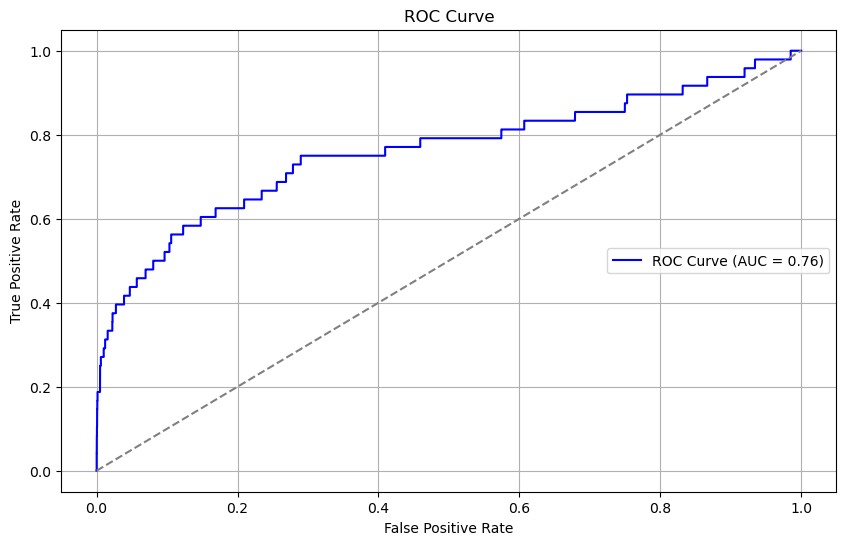

0.7608642745328245

In [ ]:
plot_roc_curve(Y_val, val_predictions)

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:74: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


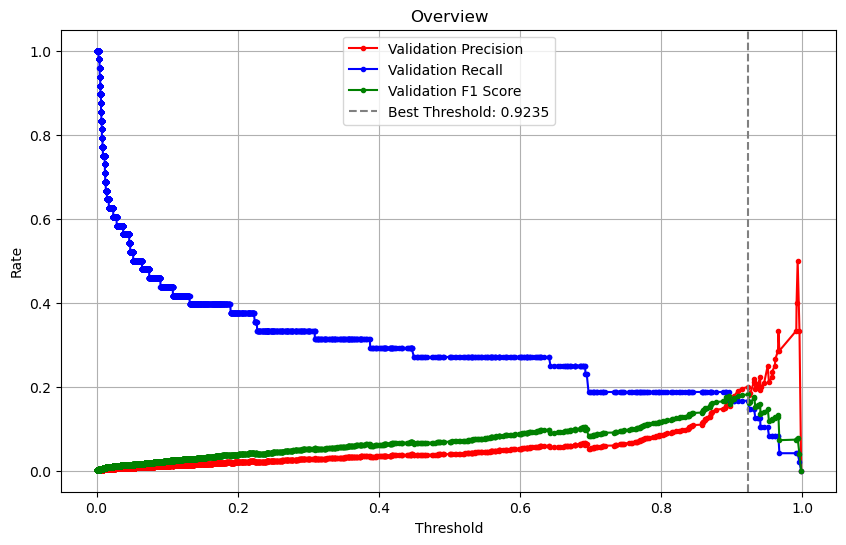

In [ ]:
best_threshold = get_best_threshold('Validation', Y_val, val_predictions)

In [ ]:
# Test model on test set
test_predictions = loaded_model.predict(X_test, batch_size=BATCH_SIZE)

17/17 [==============================] - 0s 4ms/step


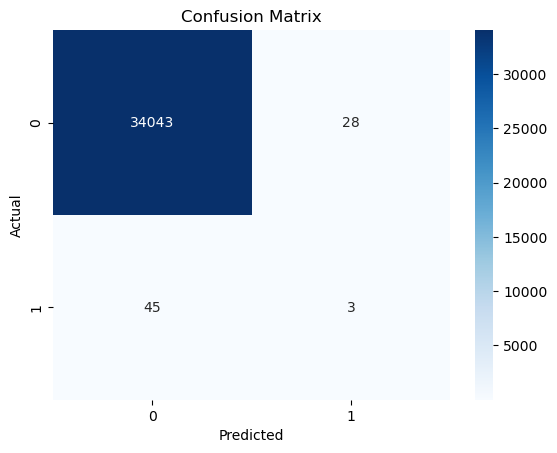

Accuracy     = 1.0
Recall       = 0.06
Precision    = 0.1
F1           = 0.08


In [ ]:
result = get_result(Y_test, test_predictions, best_threshold, visualize=True)

This is definitely not a great result. We could only find 3 out of 48 risky customers...

It could be interesting to see, how close our best threshold is to the actual best threshold for the test set, when we want to maximize the F1 score. Let's see.

/home/ykh/Repos/CreditCardApproval/Algorithms/Functions.py:74: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


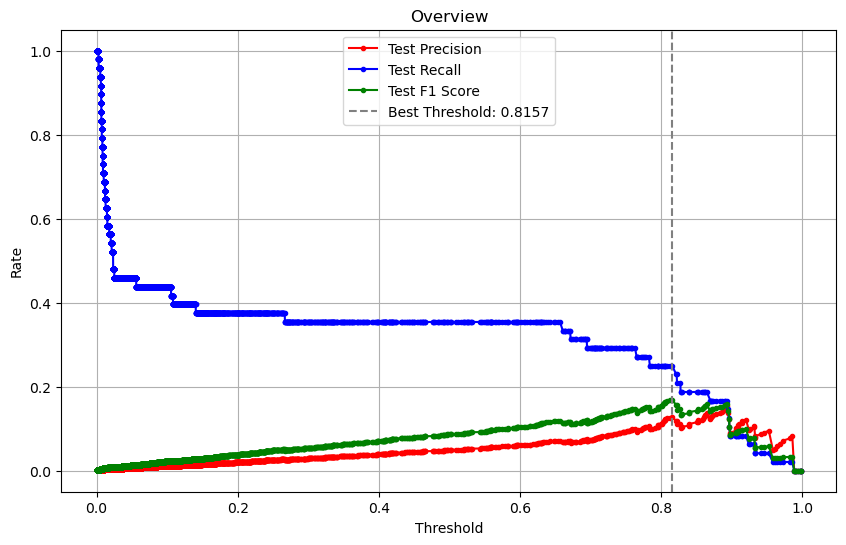

Difference between thresholds: 0.1077801


In [ ]:
best_threshold_test = get_best_threshold('Test', Y_test, test_predictions)
print('Difference between thresholds:', best_threshold - best_threshold_test)

That's pretty far off